In [1]:
'''
File : joelmodels.ipynb
Description : Linear Models
'''

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Load Data and get data description
raw_sample : pd.DataFrame = pd.read_csv("../Data/ATM_sample.csv")
raw_description : pd.DataFrame = raw_sample.describe()

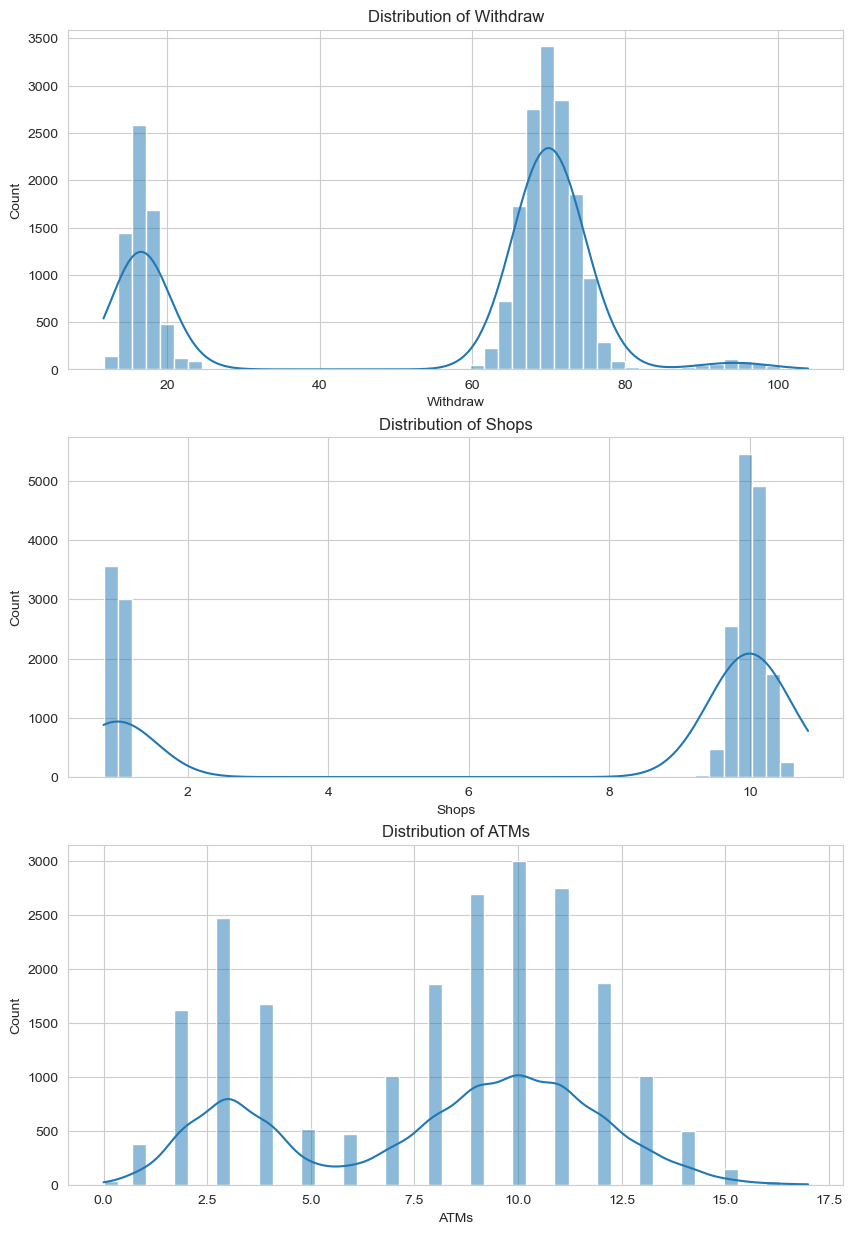

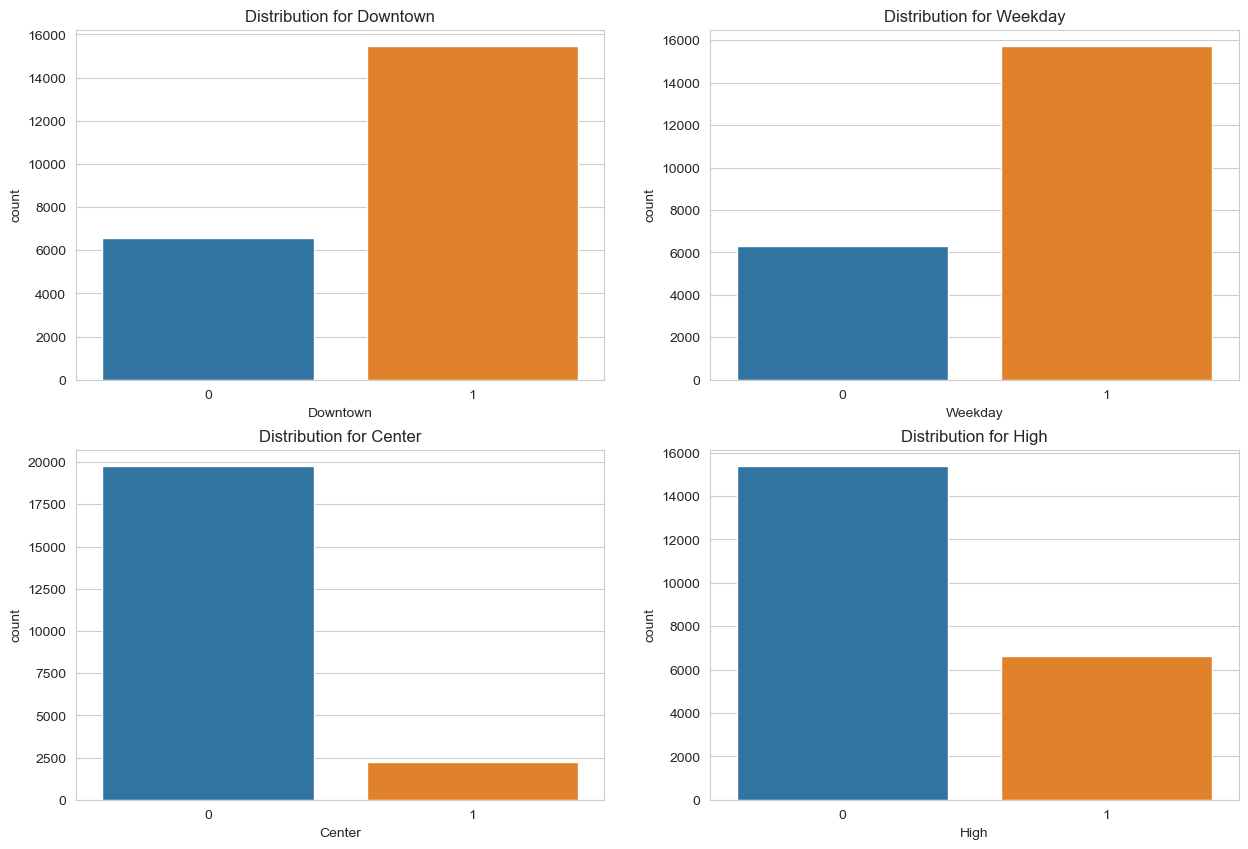

In [2]:
'''
Visualise variable distributions
'''

sns.set_style("whitegrid")
numerical_variables : list[str] = ["Withdraw", "Shops", "ATMs"]
categorical_variables : list[str] = ["Downtown", "Weekday", "Center", "High"]

# === Numerical Distributions ===

_, num_axes = plt.subplots(3, 1, figsize=(10, 15))

for i, var in enumerate(numerical_variables) :

    sns.histplot(raw_sample[var], bins=50, kde=True, ax=num_axes[i])
    num_axes[i].set_title(f"Distribution of {var}")


# === Categorical Distributions ===

_, c_axes = plt.subplots(2, 2, figsize=(15,10))
cat_axes = [a for sublist in c_axes for a in sublist]

for i, var in enumerate(categorical_variables) :

    sns.countplot(x=var, data=raw_sample, ax=cat_axes[i])
    cat_axes[i].set_title(f"Distribution for {var}")


plt.show()

### Distribution Summary

- Shops has a bimodal distribution -> Two groups of ATMs
- ATMs has a similar distribution to shops -> Two groups of ATMs
- More ATMs downtown than not
- Data collection is weighted towards weekdays
- Most ATMs did not have high cash demand last month
- Most ATMs are not in a center

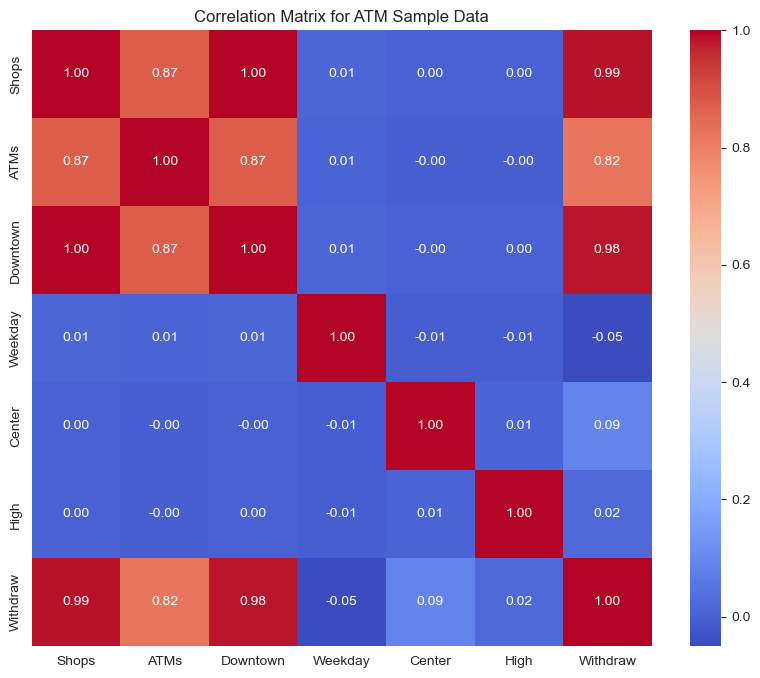

In [3]:
'''
Correlation Matrix
'''

corr_matrix : pd.DataFrame = raw_sample.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix for ATM Sample Data')
plt.show()

### Correlation Summary

- Withdraw is highly correlated with Shops, Downtown and ATMs
- Withdraw is more weakly correlated with Weekends, Center and High
- There is a high correlation between shops and downtown (Drop downtown as it has a lower correlation with Withdraw)
    > This correlation makes sense as intuitively there will be more shops downtown


/Users/joelmaxwell/miniconda3/envs/econ-unsw/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


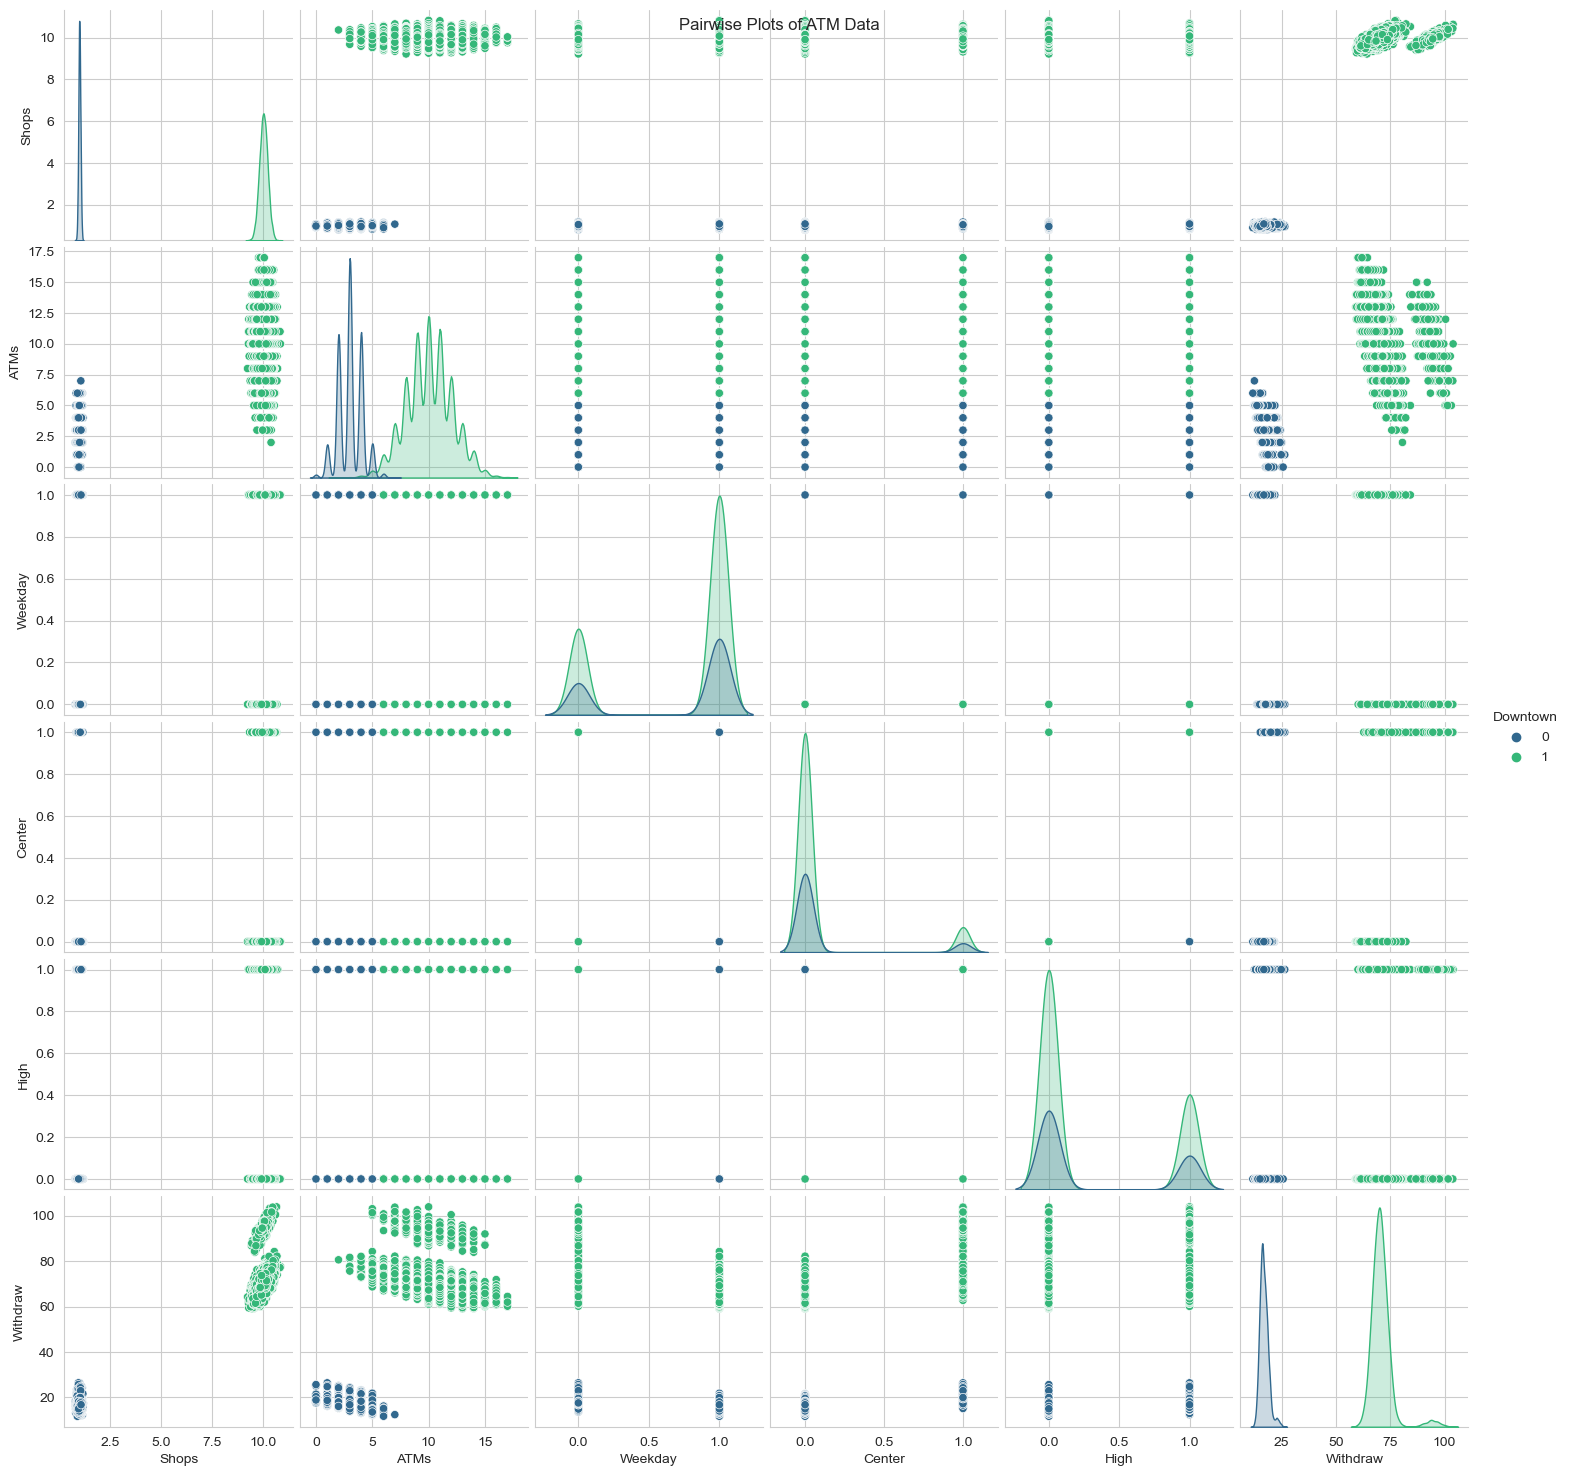

In [4]:
'''
Pairwise Plot
'''

# NOTE: Since Withdrawals is highly correlated with the binary variable downtown, set the hue variable to be Downtown to search for groupings

pairwise_plot = sns.pairplot(raw_sample, kind='scatter', diag_kind='kde', hue="Downtown", palette='viridis')
pairwise_plot.fig.suptitle("Pairwise Plots of ATM Data")
plt.show()


### Pairwise Summary

- Clear groupings in the data based on the downtown variable
- Looks to be a linear relationship between (Shops, ATMS) and Withdrawals


In [5]:
'''
Seperate features from dependent variable (x and y)
'''

y : pd.DataFrame = raw_sample['Withdraw']
x : pd.DataFrame = raw_sample.drop('Withdraw', axis=1)

numerical_variables.remove("Withdraw")

# NOTE: Drop downtown
x_no_downtown : pd.DataFrame = x.drop('Downtown', axis=1)


In [6]:
'''
Standardize : Get continuous features to be centered about zero by subtracting mean and div by std
'''

std_scaler : StandardScaler = StandardScaler()
x_scaled : np.ndarray = std_scaler.fit_transform(x_no_downtown[numerical_variables])
x_no_downtown[numerical_variables] = x_scaled


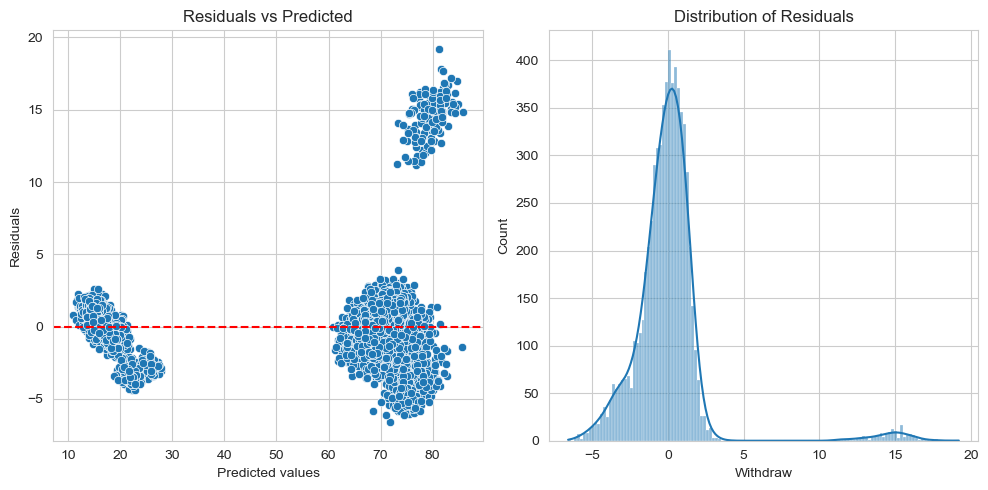

MSE : 7.026951484823352


In [7]:
'''
Fit a standard regression model
'''

X_train, X_test, y_train, y_test = train_test_split(x_no_downtown, y, test_size=0.3, random_state=23)

linear_model : LinearRegression = LinearRegression()
linear_model.fit(X_train, y_train)

y_pred : np.ndarray = linear_model.predict(X_test)
residuals : np.ndarray = y_test - y_pred

mse_std_linear : float = mean_squared_error(y_test, y_pred)

_, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.scatterplot(x=y_pred, y=residuals, ax=axs[0])
axs[0].set_title('Residuals vs Predicted')
axs[0].set_xlabel('Predicted values')
axs[0].set_ylabel('Residuals')
axs[0].axhline(y=0, color='r', linestyle='--')

sns.histplot(residuals, kde=True, ax=axs[1])
axs[1].set_title('Distribution of Residuals')

plt.tight_layout()
plt.show()

print(f"MSE : {mse_std_linear}")

### Interpretation

The distribution of residuals is slightly skewed, there may be some non-linear effects in the data.

In [8]:
'''
Add polynomial features to attempt to capture non-linear effects
'''

poly_generator : PolynomialFeatures = PolynomialFeatures(degree=2, include_bias=False)
x_polynomial : np.ndarray = poly_generator.fit_transform(x_no_downtown)

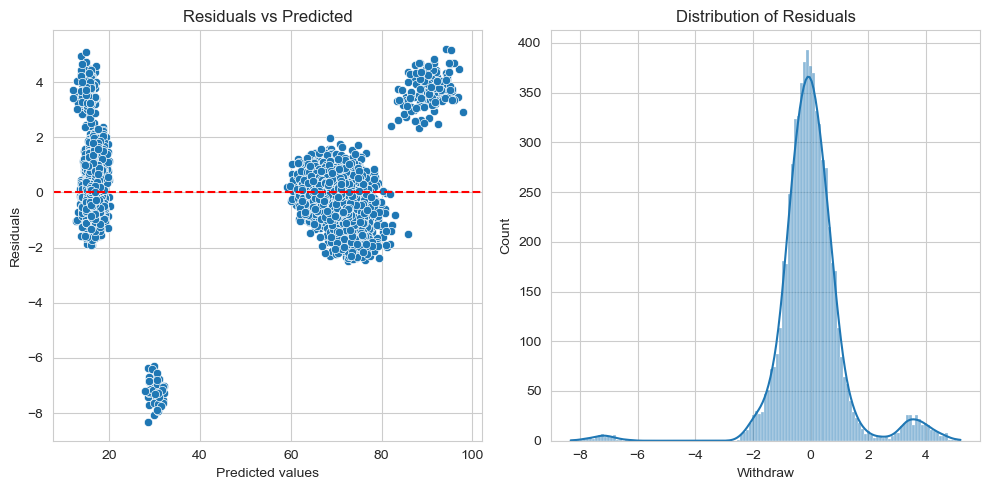

MSE : 1.5262959968416974


In [9]:
X_train, X_test, y_train, y_test = train_test_split(x_polynomial, y, test_size=0.3, random_state=23)

linear_model_w_poly : LinearRegression = LinearRegression()
linear_model_w_poly.fit(X_train, y_train)

y_pred : np.ndarray = linear_model_w_poly.predict(X_test)
residuals : np.ndarray = y_test - y_pred

mse_std_linear : float = mean_squared_error(y_test, y_pred)

_, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.scatterplot(x=y_pred, y=residuals, ax=axs[0])
axs[0].set_title('Residuals vs Predicted')
axs[0].set_xlabel('Predicted values')
axs[0].set_ylabel('Residuals')
axs[0].axhline(y=0, color='r', linestyle='--')

sns.histplot(residuals, kde=True, ax=axs[1])
axs[1].set_title('Distribution of Residuals')

plt.tight_layout()
plt.show()

print(f"MSE : {mse_std_linear}")

### Interpretation

Significantly lower MSE, in addition the distribution of residuals is far less skewed

In [10]:
'''
Ridge Regression : Do not remove downtown, instead let Ridge select
'''

x_scaled = std_scaler.fit_transform(x[numerical_variables])
x[numerical_variables] = x_scaled

poly_generator : PolynomialFeatures = PolynomialFeatures(degree=2, include_bias=False)
x_polynomial : np.ndarray = poly_generator.fit_transform(x)

X_train, X_test, y_train, y_test = train_test_split(x_polynomial, y, test_size=0.3, random_state=57)

ridge_params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

ridge = Ridge(random_state=95)
ridge_cv = GridSearchCV(ridge, ridge_params, cv=10, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train, y_train)

best_ridge_model = ridge_cv.best_estimator_

y_pred_ridge = best_ridge_model.predict(X_test)
ridge_test_error = mean_squared_error(y_test, y_pred_ridge)

print(f"MSE : {mse_std_linear}")

MSE : 1.5262959968416974
